# Checking for Bias in Ames Housing Dataset Using Classification Models

In [123]:
#Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn import tree
import seaborn as sns
import pydotplus
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load data
housing_data = pd.read_csv('../data/raw_data/ames_housing_data.csv')
income_unemp_data = pd.read_csv('../data/raw_data/income_unemp_data.csv')
walk_bike_score_data = pd.read_csv('../data/raw_data/walk_bike_score_data.csv')
school_quality_data = pd.read_csv('../data/raw_data/school_quality_data.csv')
crime_data = pd.read_csv('../data/raw_data/ames_crime.csv')

In [27]:
# Merge datasets
data = housing_data.merge(income_unemp_data, how='left', on='Neighborhood')
data = data.merge(walk_bike_score_data, how='left', on='Neighborhood')
data = data.merge(school_quality_data, how='left', on='Neighborhood')
data = data.merge(crime_data, how='left', on='Neighborhood')

In [28]:
# Drop unecessary variables
data.drop(['Id', 'Neighborhood'], axis=1, inplace=True)

In [29]:
# Count missing values
pd.set_option('display.max_rows', 500)
data.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBa

In [30]:
#Impute categorical variables where NAs represent absence of a house feature
data['Alley'].fillna('No alley access', inplace=True)
data['BsmtQual'].fillna('No Basement', inplace=True)
data['BsmtCond'].fillna('No Basement', inplace=True)
data['BsmtExposure'].fillna('No Basement', inplace=True)
data['BsmtFinType1'].fillna('No Basement', inplace=True)
data['BsmtFinType2'].fillna('No Basement', inplace=True)
data['FireplaceQu'].fillna('No Fireplace', inplace=True)
data['GarageType'].fillna('No Garage', inplace=True)
data['GarageYrBlt'].fillna('No Garage', inplace=True)
data['GarageFinish'].fillna('No Garage', inplace=True)
data['GarageQual'].fillna('No Garage', inplace=True)
data['GarageCond'].fillna('No Garage', inplace=True)
data['PoolQC'].fillna('No Pool', inplace=True)
data['Fence'].fillna('No Fence', inplace=True)
data['MiscFeature'].fillna('None', inplace=True)

In [31]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [32]:
pd.set_option('mode.chained_assignment', None)


#mapping to numerical values for KNN imputation
train['MasVnrType']= train.MasVnrType.map({"BrkCmn":1, "BrkFace":2, "CBlock":3, "Stone":4, "None":5, })
train['Electrical'] =train.Electrical.map({"SBrkr":1, "FuseA":2, "FuseF":3, "FuseP":4, "Mix":5, })
test['MasVnrType']= test.MasVnrType.map({"BrkCmn":1, "BrkFace":2, "CBlock":3, "Stone":4, "None":5, })
test['Electrical'] =test.Electrical.map({"SBrkr":1, "FuseA":2, "FuseF":3, "FuseP":4, "Mix":5, })

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', \
                         metric='nan_euclidean', copy=False, add_indicator=False)


train.loc[:,['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'BikeScore']] = \
    knn_imputer.fit_transform(train.loc[:,['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'BikeScore']])
test.loc[:,['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'BikeScore']] = \
    knn_imputer.transform(test.loc[:,['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'BikeScore']])


train['MasVnrType']= round(train['MasVnrType'])
train['Electrical']= round(train['Electrical'])
test['MasVnrType']= round(test['MasVnrType'])
test['Electrical']= round(test['Electrical'])


train['MasVnrType']= train.MasVnrType.map({1:"BrkCmn", 2:"BrkFace", 3:"CBlock", 4:"Stone", 5:"None", })
train['Electrical'] = train.Electrical.map({1:"SBrkr", 2:"FuseA", 3:"FuseF", 4:"FuseP", 5:"Mix", })   

test['MasVnrType']= test.MasVnrType.map({1:"BrkCmn", 2:"BrkFace", 3:"CBlock", 4:"Stone", 5:"None", })
test['Electrical'] = test.Electrical.map({1:"SBrkr", 2:"FuseA", 3:"FuseF", 4:"FuseP", 5:"Mix", })

In [33]:
#Sanity check for KNN Imputation
train.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

In [34]:
# Encode categorical variables as binary variables

categorical_vars = ['MSSubClass', 'MSZoning','Street','Alley', 'LotShape', 'LandContour', 'Utilities', \
                         'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',\
                         'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', \
                         'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', \
                         'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', \
                         'FireplaceQu','GarageType', 'GarageYrBlt',  'GarageFinish', 'GarageQual', 'GarageCond',\
                         'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
                        ]

for var in categorical_vars:
    train = pd.get_dummies(train, columns=[var])
    test = pd.get_dummies(test, columns=[var])

#Dropping columns from test not in train
test = test[train.columns & test.columns]

#Adding column of zeros in test for columns in train but not in test
missing_col = [col for col in train.columns if col not in test.columns]
test[missing_col] = 0

## MODEL 1

In [35]:
########MODEL 1######
##Target Variable: SalePriceAbvMean

train1 = train.copy()
test1 = test.copy()

#Creating target variable for Decision Tree based on whether SalePrice is above or below mean
train1['SalePriceAbvMean'] = 0
train1['SalePriceAbvMean'] = (train1['SalePrice'] >= data['SalePrice'].mean()).astype('int')
test1['SalePriceAbvMean'] = 0
test1['SalePriceAbvMean'] = (test1['SalePrice'] >= data['SalePrice'].mean()).astype('int')

train1.drop(['SalePrice'], axis=1, inplace=True)
test1.drop(['SalePrice'], axis=1, inplace=True)

features1 = train1.drop(columns=['SalePriceAbvMean'])
target1 = train1['SalePriceAbvMean']
features_test1 = test1.drop(columns=['SalePriceAbvMean'])
target_test1 = test1['SalePriceAbvMean']

#### Decision Tree

In [64]:
dt1 = DecisionTreeClassifier(random_state=0)


params = {
          'criterion': ['gini','entropy'],
          'max_depth': (1,3,5,10),
    'min_samples_split': (2, 5, 10)
         }


scoring = ['accuracy', 'precision', 'recall']
k = 10
grid_dt1 = GridSearchCV(estimator=dt1, 
                          param_grid=params, 
                          cv=k,
                          scoring=scoring,
                         refit = 'accuracy')

grid_dt1.fit(features1,target1)

results_dt1 = pd.DataFrame(grid_dt1.cv_results_)
results_dt1 = results_dt1.loc[:,['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
results_dt1.set_index('params', inplace=True)
results_dt1

,mean_test_accuracy,mean_test_precision,mean_test_recall
params,,,
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}",0.852697,0.813907,0.795000
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}",0.852697,0.813907,0.795000
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10}",0.852697,0.813907,0.795000
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}",0.888653,0.839967,0.876364
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5}",0.888653,0.839967,0.876364
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}",0.888653,0.839967,0.876364
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}",0.886074,0.852378,0.851364
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}",0.882648,0.851551,0.842374
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}",0.882648,0.849357,0.844596


best parameters {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


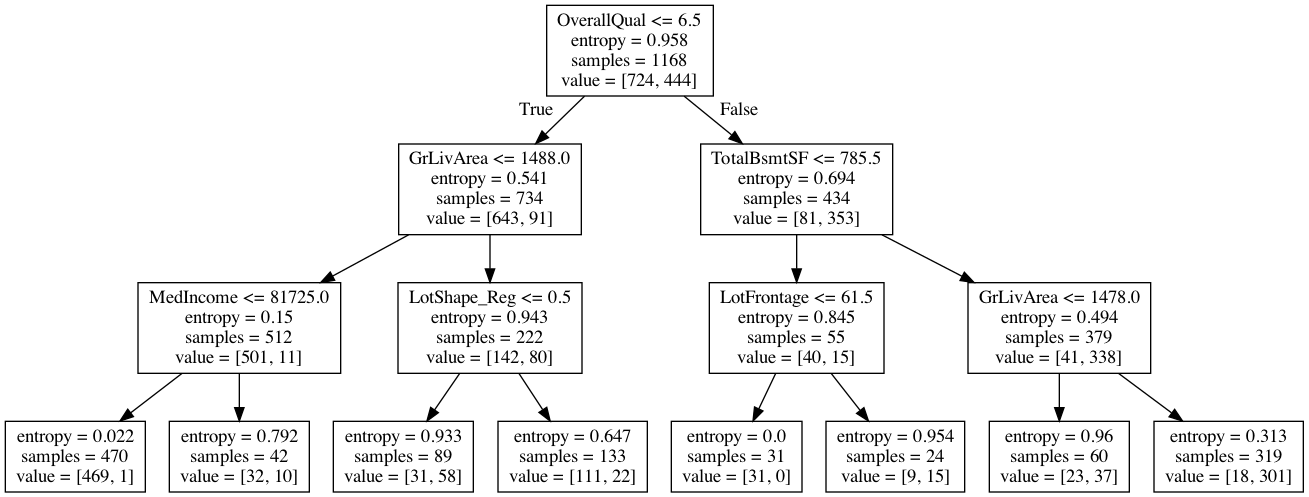

In [61]:
dt_best1 = DecisionTreeClassifier(random_state=0)
best_params_dt1 = grid_dt1.best_params_
dt_best1.set_params(**best_params_dt1, random_state = 0)
print('best parameters', best_params_dt1)

model_dt1 = dt_best1.fit(features1,target1)

labels_dt1 = features1.columns.values
dot_data = tree.export_graphviz(model_dt1, out_file=None, feature_names=labels_dt1)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [62]:
target_pred_dt1 = dt_best1.predict(features_test1)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test1, target_pred_dt1),
                                                                           metrics.precision_score(target_test1, target_pred_dt1),
                                                                           metrics.recall_score(target_test1, target_pred_dt1),
                                                                           metrics.f1_score(target_test1, target_pred_dt1)
                                                                          ))


Accuracy:	0.8664383561643836
Precision:	0.8130081300813008
Recall:		0.8620689655172413
F1 Score:	0.8368200836820082


#### Random Forest Classifier

In [45]:
rf1 = RandomForestClassifier(random_state=0, 
                            n_jobs=-1,
                            class_weight='balanced'
                           )


params = {
           'criterion': ['gini','entropy'],
          'n_estimators': (100, 200),
          'max_depth': (1,3,5),
         'min_samples_split': (2, 5, 10)
         }



grid_rf1 = GridSearchCV(estimator=rf1, 
                          param_grid=params, 
                          cv=k,
                          scoring= scoring,
                         refit = 'accuracy')


grid_rf1.fit(features1,target1)


results_rf1 = pd.DataFrame(grid_rf1.cv_results_)
results_rf1 = results_rf1.loc[:,['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
results_rf1.set_index('params', inplace=True)
results_rf1

,mean_test_accuracy,mean_test_precision,mean_test_recall
params,,,
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.861200,0.805111,0.841970
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.880077,0.819531,0.882727
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.861200,0.805111,0.841970
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.880077,0.819531,0.882727
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 100}",0.861200,0.805111,0.841970
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 200}",0.880077,0.819531,0.882727
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}",0.893759,0.844562,0.887273
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}",0.898902,0.849558,0.896313
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}",0.892897,0.843856,0.885000


In [96]:
# rf_best1 = RandomForestClassifier(random_state=0, 
#                             n_jobs=-1,
#                             class_weight='balanced'
#                            )
# best_params_rf1 = grid_rf1.best_params_
# rf_best1.set_params(**best_params_rf1, random_state = 0)

# print('best parameters', best_params_rf1)


# model_rf1 = rf_best1.fit(features1,target1)



# labels_rf1 = features1.columns.values
# dot_data = tree.export_graphviz(model_rf1, out_file=None, feature_names=labels_rf1)

# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [48]:
rf_best1 = RandomForestClassifier(random_state=0, 
                            n_jobs=-1,
                            class_weight='balanced'
                           )
best_params_rf1 = grid_rf1.best_params_
rf_best1.set_params(**best_params_rf1, random_state = 0)

print('best parameters', best_params_rf1)


rf_best1.fit(features1,target1)


target_pred_rf1 = rf_best1.predict(features_test1)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test1, target_pred_rf1),
                                                                           metrics.precision_score(target_test1, target_pred_rf1),
                                                                           metrics.recall_score(target_test1, target_pred_rf1),
                                                                           metrics.f1_score(target_test1, target_pred_rf1)
                                                                          ))

Accuracy:	0.910958904109589
Precision:	0.8813559322033898
Recall:		0.896551724137931
F1 Score:	0.888888888888889


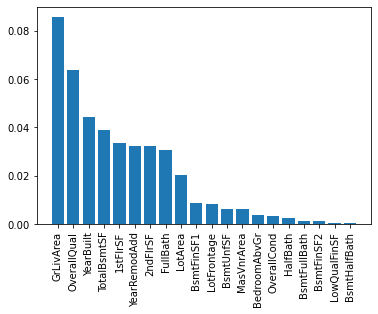

In [67]:
#Looking at feature Importance of 20 most important features

importances_rf1 = rf_best1.feature_importances_[:20]

indices_rf1 = np.argsort(importances_rf1)[::-1]


labels_rf1 = features1.columns.values
names_rf1 = [labels_rf1[i] for i in indices_rf1]

plt.figure()
plt.bar(range(20),importances_rf1[indices_rf1])
plt.xticks(range(20), names1, rotation=90)
plt.show()

#### Decision Tree Regressor

best parameters {'max_depth': 3}


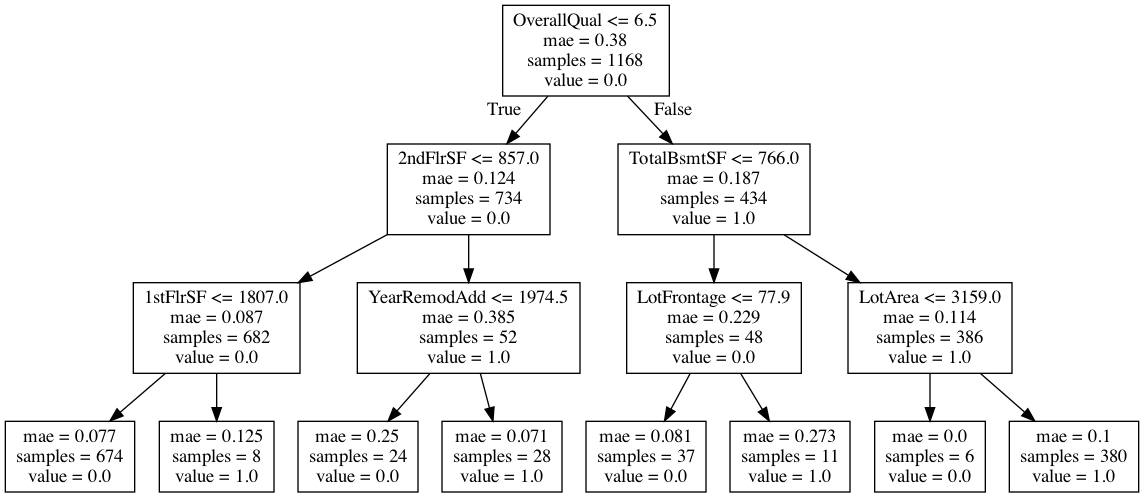

In [66]:
dt_reg1 = DecisionTreeRegressor(criterion = "mae", random_state = 0)

params = {
          'max_depth': (1,3,5)
         }

grid_dt_reg1 = GridSearchCV(estimator=dt_reg1, 
                          param_grid=params, 
                          cv=k,
                          scoring= scoring,
                         refit = 'accuracy')


grid_dt_reg1.fit(features1,target1)

dt_reg_best1 = DecisionTreeRegressor(criterion = "mae", random_state = 0)
best_params_dt_reg1 = grid_dt_reg1.best_params_
dt_reg_best1.set_params(**best_params_dt_reg1, random_state = 0)
print('best parameters', best_params_dt_reg1)

model_dt_reg1 = dt_reg_best1.fit(features1,target1)

labels_dt_reg1 = features1.columns.values
dot_data = tree.export_graphviz(model_dt_reg1, out_file=None, feature_names=labels_dt_reg1)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [69]:
target_pred_dt_reg1 = dt_reg_best1.predict(features_test1)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test1, target_pred_dt_reg1),
                                                                           metrics.precision_score(target_test1, target_pred_dt_reg1),
                                                                           metrics.recall_score(target_test1, target_pred_dt_reg1),
                                                                           metrics.f1_score(target_test1, target_pred_dt_reg1)
                                                                          ))

Accuracy:	0.8664383561643836
Precision:	0.8407079646017699
Recall:		0.8189655172413793
F1 Score:	0.8296943231441049


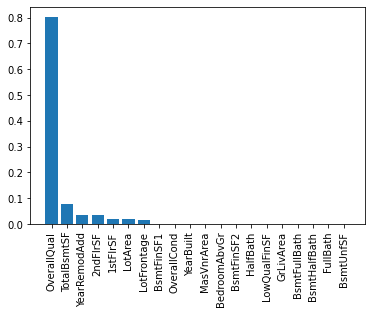

In [59]:
#Looking at feature Importance of 20 most important features

importances_dt_reg1 = dt_reg_best1.feature_importances_[:20]

indices_dt_reg1 = np.argsort(importances_dt_reg1)[::-1]


labels_dt_reg1 = features1.columns.values
names_dt_reg1 = [labels_dt_reg1[i] for i in indices_dt_reg1]

plt.figure()
plt.bar(range(20),importances_dt_reg1[indices_dt_reg1])
plt.xticks(range(20), names_dt_reg1, rotation=90)
plt.show()

## MODEL 2

In [72]:
########MODEL 2######
##Target Variable: SalePriceLvl

train2 = train.copy()
test2 = test.copy()

#Creating multi-level target variable for Decision Tree based on the cut-offs from clustering model 

train2['SalePriceLvl'] = 0
train2['SalePriceLvl'][train2['SalePrice'] < 174000] = 'Low'
train2['SalePriceLvl'][(train2['SalePrice'] >= 174000) & (train2['SalePrice'] < 290000)] = 'Medium'
train2['SalePriceLvl'][train2['SalePrice'] >= 290000] = 'High'


test2['SalePriceLvl'] = 0
test2['SalePriceLvl'][test2['SalePrice'] < 174000] = 'Low'
test2['SalePriceLvl'][(test2['SalePrice'] >= 174000) & (test2['SalePrice'] < 290000)] = 'Medium'
test2['SalePriceLvl'][test2['SalePrice'] >= 290000] = 'High'

train2.drop(['SalePrice'], axis=1, inplace=True)
test2.drop(['SalePrice'], axis=1, inplace=True)

features2 = train2.drop(columns=['SalePriceLvl'])
target2 = train2['SalePriceLvl']
features_test2 = test2.drop(columns=['SalePriceLvl'])
target_test2 = test2['SalePriceLvl']

### Decision Tree

In [99]:
pd.set_option('mode.chained_assignment', None)

dt2 = DecisionTreeClassifier(random_state=0)


params = {
          'criterion': ['gini','entropy'],
          'max_depth': (1,3,5,10),
    'min_samples_split': (2, 5, 10)
         }


scorer = {}
scorer['accuracy'] = make_scorer(metrics.accuracy_score)
scorer['precision'] = make_scorer(metrics.precision_score, average = 'weighted')
scorer['recall'] = make_scorer(metrics.recall_score, average = 'weighted')

# k = 10
grid_dt2 = GridSearchCV(estimator=dt2, 
                          param_grid=params, 
                          cv=k,
                          scoring=scorer,
                         refit = 'accuracy')

grid_dt2.fit(features2,target2)

results_dt2 = pd.DataFrame(grid_dt2.cv_results_)
results_dt2 = results_dt2.loc[:,['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
results_dt2.set_index('params', inplace=True)
results_dt2

,mean_test_accuracy,mean_test_precision,mean_test_recall
params,,,
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}",0.758532,0.691854,0.758532
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}",0.758532,0.691854,0.758532
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10}",0.758532,0.691854,0.758532
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}",0.811634,0.813487,0.811634
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5}",0.811634,0.813487,0.811634
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}",0.811634,0.813487,0.811634
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}",0.819327,0.823738,0.819327
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}",0.820181,0.824690,0.820181
"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}",0.821891,0.826785,0.821891


best parameters {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}


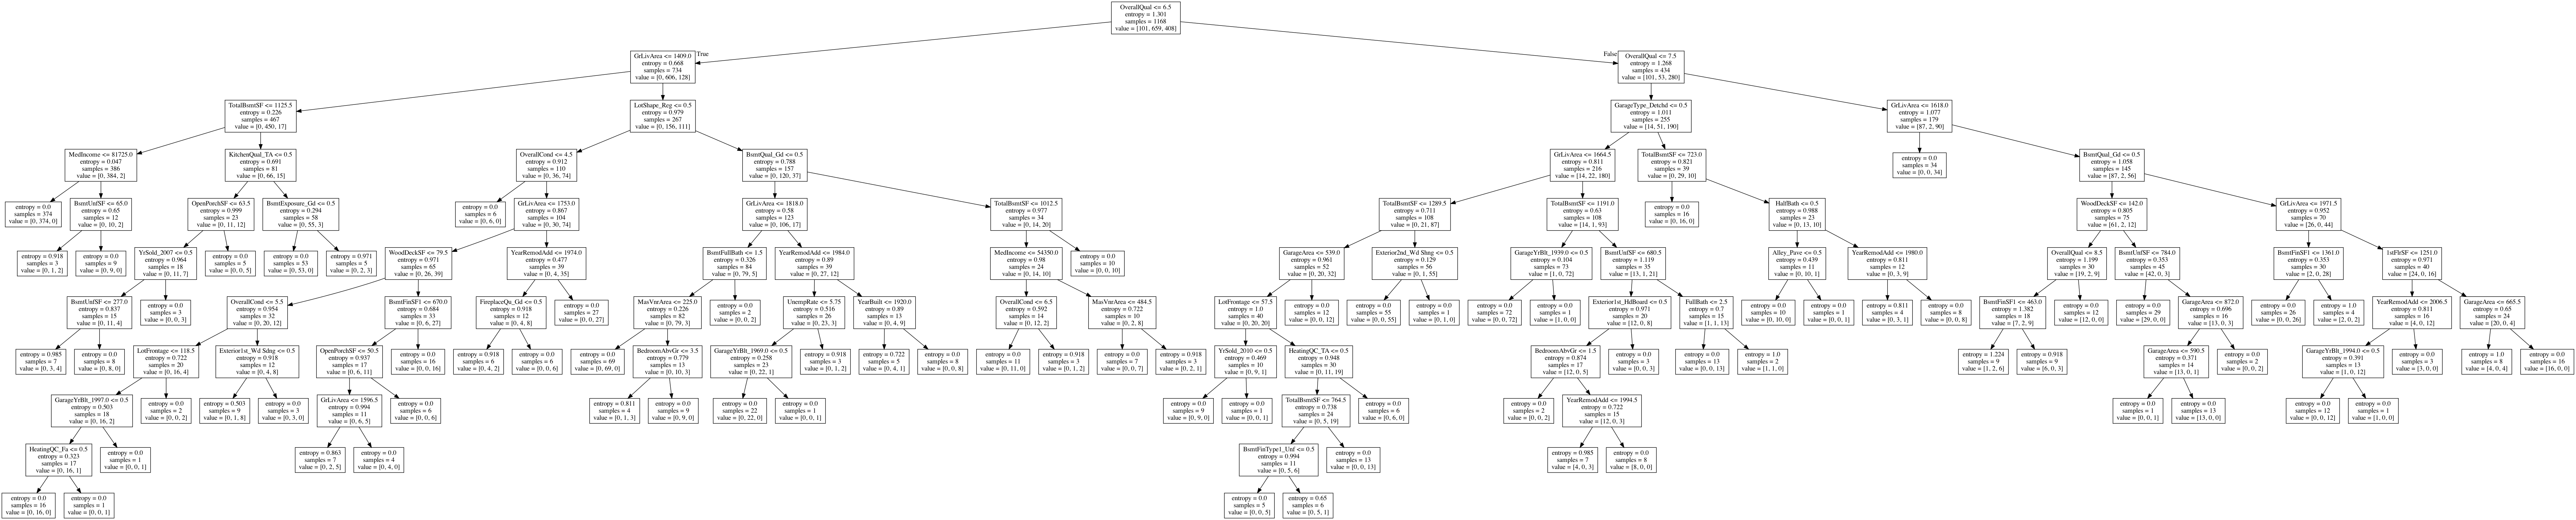

In [86]:
dt_best2 = DecisionTreeClassifier(random_state=0)
best_params_dt2 = grid_dt2.best_params_
dt_best2.set_params(**best_params_dt2, random_state = 0)
print('best parameters', best_params_dt2)

model_dt2 = dt_best2.fit(features2,target2)

labels_dt2 = features2.columns.values
dot_data = tree.export_graphviz(model_dt2, out_file=None, feature_names=labels_dt2)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [87]:
target_pred_dt2 = dt_best2.predict(features_test2)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test2.astype('str'), target_pred_dt2.astype('str')),
                                                                           metrics.precision_score(target_test2.astype('str'), target_pred_dt2.astype('str'), average='weighted'),
                                                                           metrics.recall_score(target_test2.astype('str'), target_pred_dt2.astype('str'), average='weighted'),
                                                                           metrics.f1_score(target_test2.astype('str'), target_pred_dt2.astype('str'), average='weighted')
                                                                          ))


Accuracy:	0.7842465753424658
Precision:	0.7896416917571765
Recall:		0.7842465753424658
F1 Score:	0.784726384377061


### Random Forest Classifier

In [88]:
rf2 = RandomForestClassifier(random_state=0, 
                            n_jobs=-1,
                            class_weight='balanced'
                           )


params = {
           'criterion': ['gini','entropy'],
          'n_estimators': (100, 200),
          'max_depth': (1,3,5),
         'min_samples_split': (2, 5, 10)
         }



grid_rf2 = GridSearchCV(estimator=rf2, 
                          param_grid=params, 
                          cv=k,
                          scoring= scorer,
                         refit = 'accuracy')


grid_rf2.fit(features2,target2)


results_rf2 = pd.DataFrame(grid_rf2.cv_results_)
results_rf2 = results_rf2.loc[:,['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
results_rf2.set_index('params', inplace=True)
results_rf2

,mean_test_accuracy,mean_test_precision,mean_test_recall
params,,,
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.749167,0.787912,0.749167
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.770594,0.811470,0.770594
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.749167,0.787912,0.749167
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.770594,0.811470,0.770594
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 100}",0.749167,0.787912,0.749167
"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 200}",0.770594,0.811470,0.770594
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}",0.852726,0.857507,0.852726
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}",0.845889,0.851164,0.845889
"{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}",0.851849,0.856628,0.851849


In [89]:
rf_best2 = RandomForestClassifier(random_state=0, 
                            n_jobs=-1,
                            class_weight='balanced'
                           )
best_params_rf2 = grid_rf2.best_params_
rf_best2.set_params(**best_params_rf2, random_state = 0)

print('best parameters', best_params_rf2)


rf_best2.fit(features2,target2)


target_pred_rf2 = rf_best2.predict(features_test2)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test2.astype('str'), target_pred_rf2.astype('str')),
                                                                           metrics.precision_score(target_test2.astype('str'), target_pred_rf2.astype('str'), average='weighted'),
                                                                           metrics.recall_score(target_test2.astype('str'), target_pred_rf2.astype('str'), average='weighted'),
                                                                           metrics.f1_score(target_test2.astype('str'), target_pred_rf2.astype('str'), average='weighted')
                                                                          ))


best parameters {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy:	0.8527397260273972
Precision:	0.852892718084759
Recall:		0.8527397260273972
F1 Score:	0.8524590022799426


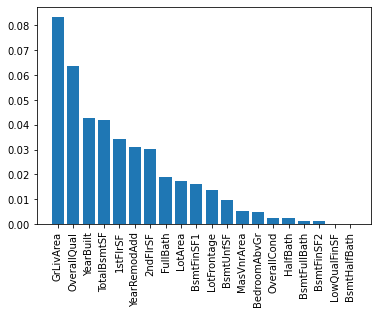

In [90]:
#Looking at feature Importance of 20 most important features

importances_rf2 = rf_best2.feature_importances_[:20]

indices_rf2 = np.argsort(importances_rf2)[::-1]


labels_rf2 = features2.columns.values
names_rf2 = [labels_rf2[i] for i in indices_rf2]

plt.figure()
plt.bar(range(20),importances_rf2[indices_rf2])
plt.xticks(range(20), names1, rotation=90)
plt.show()

### Decision Tree Regressor

best parameters {'max_depth': 5}


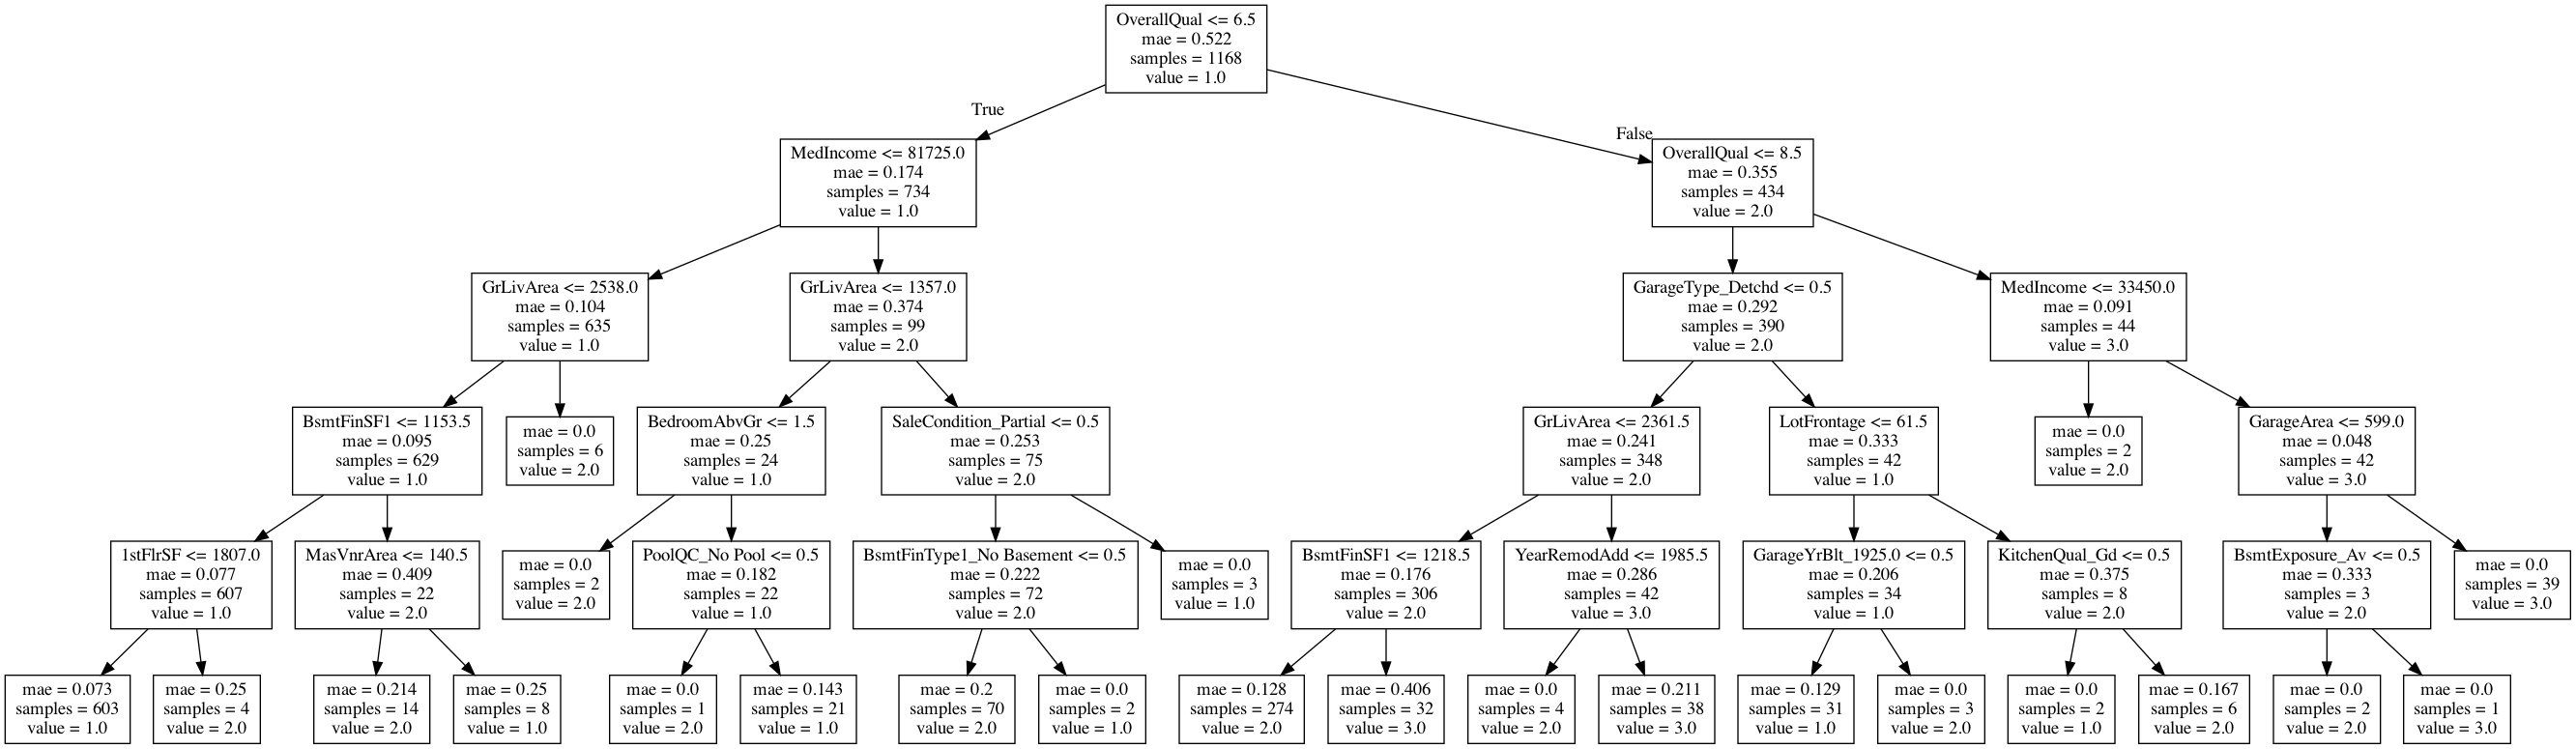

In [100]:
target2_dt_reg = target2.copy()
target2_dt_reg = target2_dt_reg.map({"Low":1, "Medium":2, "High":3})

target_test_dt_reg2 = target_test2.copy()
target_test_dt_reg2 = target_test_dt_reg2.map({"Low":1, "Medium":2, "High":3})


dt_reg2 = DecisionTreeRegressor(criterion = "mae", random_state = 0)

params = {
          'max_depth': (1,3,5)
         }


grid_dt_reg2 = GridSearchCV(estimator=dt_reg2, 
                          param_grid=params, 
                          cv=k,
                          scoring= scorer,
                         refit = 'accuracy')


grid_dt_reg2.fit(features2,target2_dt_reg)

dt_reg_best2 = DecisionTreeRegressor(criterion = "mae", random_state = 0)
best_params_dt_reg2 = grid_dt_reg2.best_params_
dt_reg_best2.set_params(**best_params_dt_reg2, random_state = 0)
print('best parameters', best_params_dt_reg2)

model_dt_reg2 = dt_reg_best2.fit(features2,target2_dt_reg)

labels_dt_reg2 = features2.columns.values
dot_data = tree.export_graphviz(model_dt_reg2, out_file=None, feature_names=labels_dt_reg2)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [94]:
target_pred_dt_reg2 = dt_reg_best2.predict(features_test2)

print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}".format(metrics.accuracy_score(target_test_dt_reg2, target_pred_dt_reg2),
                                                                           metrics.precision_score(target_test_dt_reg2, target_pred_dt_reg2, average='weighted'),
                                                                           metrics.recall_score(target_test_dt_reg2, target_pred_dt_reg2, average='weighted'),
                                                                           metrics.f1_score(target_test_dt_reg2, target_pred_dt_reg2, average='weighted')
                                                                          ))

Accuracy:	0.8287671232876712
Precision:	0.8332633160476209
Recall:		0.8287671232876712
F1 Score:	0.8300201099644532


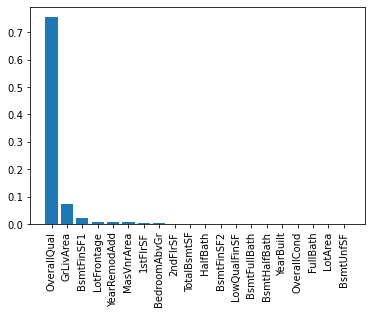

In [95]:
#Looking at feature Importance of 20 most important features

importances_dt_reg2 = dt_reg_best2.feature_importances_[:20]

indices_dt_reg2 = np.argsort(importances_dt_reg2)[::-1]


labels_dt_reg2 = features2.columns.values
names_dt_reg2 = [labels_dt_reg2[i] for i in indices_dt_reg2]

plt.figure()
plt.bar(range(20),importances_dt_reg2[indices_dt_reg2])
plt.xticks(range(20), names_dt_reg2, rotation=90)
plt.show()

In [107]:

error = pd.DataFrame()
error['SalePriceLvl'] = target_test2
error ['SalePriceLvl_hat'] = target_pred_rf2
error ['SalePriceAbvMean_hat'] = target_pred_rf1
error ['SalePriceAbvMean'] = target_test1

In [120]:
#Using RF Model 2 labels as base labels to compare Model 1 actual and predicated labels 


low_undervalued = error[(error['SalePriceLvl'] == 'Low') & \
                        (error['SalePriceAbvMean_hat'] > error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'Low')].shape[0]

low_overvalued = error[(error['SalePriceLvl'] == 'Low') & \
                        (error['SalePriceAbvMean_hat'] < error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'Low')].shape[0]

med_undervalued = error[(error['SalePriceLvl'] == 'Medium') & \
                        (error['SalePriceAbvMean_hat'] > error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'Medium')].shape[0]

med_overvalued = error[(error['SalePriceLvl'] == 'Medium') & \
                        (error['SalePriceAbvMean_hat'] < error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'Medium')].shape[0]

high_undervalued = error[(error['SalePriceLvl'] == 'High') & \
                        (error['SalePriceAbvMean_hat'] > error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'High')].shape[0]


high_overvalued = error[(error['SalePriceLvl'] == 'High') & \
                        (error['SalePriceAbvMean_hat'] < error['SalePriceAbvMean'])].shape[0] \
/ error[(error['SalePriceLvl'] == 'High')].shape[0]

(0.0, 1.0)

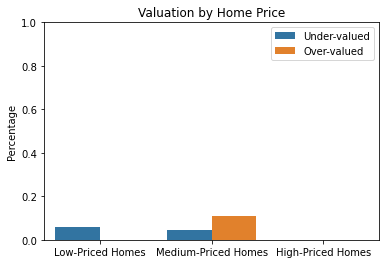

In [124]:
fairness_data = pd.DataFrame({'Percentage' : [low_undervalued, low_overvalued, med_undervalued, med_overvalued,
                                                  high_undervalued, high_overvalued],
                                  'Valuation Error' : ['Under-valued', 'Over-valued', 'Under-valued', 'Over-valued',
                                                       'Under-valued','Over-valued'],
                                  'Cluster': ['Low-Priced Homes', 'Low-Priced Homes', 'Medium-Priced Homes',
                                              'Medium-Priced Homes', 'High-Priced Homes', 'High-Priced Homes']})
plot = sns.barplot(x='Cluster', y='Percentage', hue='Valuation Error', data=fairness_data)
plot.legend_.set_title('')
plot.set_title('Valuation by Home Price')
plot.set_xlabel('')
plt.ylim((0, 1))

In [145]:
#Using RF Model 1 labels as base labels to compare Model 2 actual and predicated labels 

low_undervalued = error[(error['SalePriceAbvMean'] == 0) 
      & (
          (
              ((error['SalePriceLvl'] == 'Low') & (error['SalePriceLvl_hat'] == 'High')) |
              ((error['SalePriceLvl'] == 'Low') & (error['SalePriceLvl_hat'] == 'Medium'))
          )| 
          ((error['SalePriceLvl'] == 'Medium') & (error['SalePriceLvl_hat'] =='High'))
      )].shape[0] / error[error['SalePriceAbvMean'] == 0].shape[0]

low_overvalued = error[(error['SalePriceAbvMean'] == 0) 
      & (
          (
              ((error['SalePriceLvl'] == 'High') & (error['SalePriceLvl_hat'] == 'Low')) |
              ((error['SalePriceLvl'] == 'High') & (error['SalePriceLvl_hat'] == 'Medium'))
          )| 
          ((error['SalePriceLvl'] == 'Medium') & (error['SalePriceLvl_hat'] =='Low'))
      )].shape[0] / error[error['SalePriceAbvMean'] == 0].shape[0]



high_undervalued = error[(error['SalePriceAbvMean'] == 1) 
      & (
          (
              ((error['SalePriceLvl'] == 'Low') & (error['SalePriceLvl_hat'] == 'High')) |
              ((error['SalePriceLvl'] == 'Low') & (error['SalePriceLvl_hat'] == 'Medium'))
          )| 
          ((error['SalePriceLvl'] == 'Medium') & (error['SalePriceLvl_hat'] =='High'))
      )].shape[0] / error[error['SalePriceAbvMean'] == 1].shape[0]


low_overvalued = error[(error['SalePriceAbvMean'] == 1) 
      & (
          (
              ((error['SalePriceLvl'] == 'High') & (error['SalePriceLvl_hat'] == 'Low')) |
              ((error['SalePriceLvl'] == 'High') & (error['SalePriceLvl_hat'] == 'Medium'))
          )| 
          ((error['SalePriceLvl'] == 'Medium') & (error['SalePriceLvl_hat'] =='Low'))
      )].shape[0] / error[error['SalePriceAbvMean'] == 1].shape[0]


(0.0, 1.0)

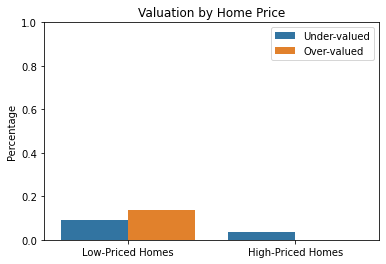

In [146]:
fairness_data = pd.DataFrame({'Percentage' : [low_undervalued, low_overvalued, high_undervalued, high_overvalued],
                                  'Valuation Error' : ['Under-valued', 'Over-valued', 'Under-valued', 'Over-valued'],
                                  'Cluster': ['Low-Priced Homes', 'Low-Priced Homes', 'High-Priced Homes', 'High-Priced Homes']})
plot = sns.barplot(x='Cluster', y='Percentage', hue='Valuation Error', data=fairness_data)
plot.legend_.set_title('')
plot.set_title('Valuation by Home Price')
plot.set_xlabel('')
plt.ylim((0, 1))